In [1]:
import torch
print("GPU is available!")
print("GPU Name:", torch.cuda.get_device_name(0))
print("CUDA version:", torch.version.cuda)

GPU is available!
GPU Name: NVIDIA RTX A4000
CUDA version: 11.8


In [2]:
from transformers import TrainingArguments,Trainer

C:\Users\FAST\.conda\envs\torchgpu\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Preprocessing

In [3]:
from datasets import load_dataset

ds = load_dataset("scikit-learn/imdb")

In [4]:
ds

DatasetDict({
    train: Dataset({
        features: ['review', 'sentiment'],
        num_rows: 50000
    })
})

In [5]:
dataset = ds["train"].select(range(5000))
dataset

Dataset({
    features: ['review', 'sentiment'],
    num_rows: 5000
})

In [6]:
print(dataset['review'][10])

Phil the Alien is one of those quirky films where the humour is based around the oddness of everything rather than actual punchlines.<br /><br />At first it was very odd and pretty funny but as the movie progressed I didn't find the jokes or oddness funny anymore.<br /><br />Its a low budget film (thats never a problem in itself), there were some pretty interesting characters, but eventually I just lost interest.<br /><br />I imagine this film would appeal to a stoner who is currently partaking.<br /><br />For something similar but better try "Brother from another planet"


In [32]:
from transformers import RobertaTokenizer
from transformers import RobertaForSequenceClassification

model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)  # for binary classification

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

text = dataset['review'][10]
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
# (output)

In [9]:
# encoded_input

In [10]:
# tokenizer.tokenize(text)

In [11]:
def tokenize_function(examples):
    return tokenizer(examples["review"], padding="max_length", truncation=True)

dataset = dataset.map(tokenize_function, batched=True)
dataset

Dataset({
    features: ['review', 'sentiment', 'input_ids', 'attention_mask'],
    num_rows: 5000
})

In [12]:
label2id = {"negative": 0, "positive": 1}
id2label = {0: "negative", 1: "positive"}

def encode_labels(example):
    example["sentiment"] = label2id[example["sentiment"]]
    return example

# Assuming your dataset is already loaded as `dataset`
dataset = dataset.map(encode_labels)

In [13]:
dataset = dataset.rename_column("sentiment", "label")
dataset

Dataset({
    features: ['review', 'label', 'input_ids', 'attention_mask'],
    num_rows: 5000
})

In [14]:
split_data=dataset.train_test_split(test_size=0.1)
training_set=split_data['train']
test_set=split_data['test']

split_data=training_set.train_test_split(test_size=0.1)
training_set=split_data['train']
validation_set=split_data['test']

print(training_set)
print(test_set)
print(validation_set)

Dataset({
    features: ['review', 'label', 'input_ids', 'attention_mask'],
    num_rows: 4050
})
Dataset({
    features: ['review', 'label', 'input_ids', 'attention_mask'],
    num_rows: 500
})
Dataset({
    features: ['review', 'label', 'input_ids', 'attention_mask'],
    num_rows: 450
})


# Full Fine-Tuning

In [23]:
from sklearn.metrics import accuracy_score
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc}

In [15]:
from transformers import TrainingArguments,Trainer

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,                 # Often enough with good LR sched
    per_device_train_batch_size=32,     # Use 32 instead of 16 – A4000 can handle it
    per_device_eval_batch_size=64,      # Evaluation can usually be larger

    learning_rate=3e-5,                 # Default LR, tune if needed
    warmup_steps=250,                   # Lower warmup for smaller dataset
    weight_decay=0.01,

    metric_for_best_model="accuracy",
    
    logging_dir='./logs',
)

In [16]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=training_set,
    eval_dataset=validation_set,
    compute_metrics=compute_metrics,
)

In [17]:
import time

start_time = time.time()
trainer.train()
end_time = time.time()
 
total_time = end_time - start_time
print(f"Training Time: {total_time:.2f} seconds")

Step,Training Loss
500,0.240700


Training Time: 821.37 seconds


In [18]:
test_results = trainer.evaluate(test_set)
print(f"Test Accuracy: {test_results['eval_accuracy']:.4f}")

Test Accuracy: 0.9360


In [19]:
from torchinfo import summary  # Optional: pip install torchinfo

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Trainable Parameters: {count_parameters(model):,}")


Trainable Parameters: 124,647,170


In [20]:
import torch

# Max memory used during training
max_mem = torch.cuda.max_memory_allocated() / (1024 ** 3)
print(f"Max GPU memory used: {max_mem:.2f} GB")

Max GPU memory used: 11.07 GB


# LoRA Fine-Tuning using PEFT

In [21]:
from peft import LoraConfig, get_peft_model, TaskType

In [22]:
from peft import LoraConfig, get_peft_model, TaskType

lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["query", "value"],  # Roberta uses q, v (not 'q_proj', 'v_proj')
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.SEQ_CLS
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()  # check how few are trainable!

trainable params: 887,042 || all params: 125,534,212 || trainable%: 0.7066


In [23]:
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=5,
    logging_dir="./logs",
    save_strategy="epoch",
    report_to="none",
)

In [21]:
from transformers import Trainer

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        # Remove unexpected arguments
        inputs = {k: v for k, v in inputs.items() if k != "num_items_in_batch"}
        outputs = model(**inputs)
        loss = outputs.loss
        return (loss, outputs) if return_outputs else loss

In [25]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=training_set,
    eval_dataset=validation_set,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

C:\Users\FAST\AppData\Local\Temp\ipykernel_14580\3348580338.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [26]:
import time

start_time = time.time()
trainer.train()
end_time = time.time()
 
total_time = end_time - start_time
print(f"Training Time: {total_time:.2f} seconds")

Step,Training Loss
500,0.029100


Training Time: 660.74 seconds


In [27]:
test_results = trainer.evaluate(test_set)
print(f"Test Accuracy: {test_results['eval_accuracy']:.4f}")

Test Accuracy: 0.9340


In [28]:
from torchinfo import summary  # Optional: pip install torchinfo

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Trainable Parameters: {count_parameters(model):,}")

Trainable Parameters: 887,042


In [29]:
import torch

# Max memory used during training
max_mem = torch.cuda.max_memory_allocated() / (1024 ** 3)
print(f"Max GPU memory used: {max_mem:.2f} GB")

Max GPU memory used: 11.07 GB


# QLoRA Fine-Tuning

In [15]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype="float16",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4"
)

In [16]:
model = RobertaForSequenceClassification.from_pretrained("roberta-base",quantization_config=bnb_config,device_map="auto", num_labels=2)  # for binary 

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
from peft import prepare_model_for_kbit_training
# Enable gradient checkpointing and other prep
model = prepare_model_for_kbit_training(model)

In [18]:
from peft import LoraConfig, get_peft_model, TaskType

lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["query", "value"],  # or try full paths if this fails
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.SEQ_CLS
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 887,042 || all params: 125,534,212 || trainable%: 0.7066


In [19]:
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=4,
    num_train_epochs=5,
    logging_dir="./logs",
    save_strategy="epoch",
    report_to="none",
    fp16=True,
)

In [24]:
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=training_set,
    eval_dataset=validation_set,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

C:\Users\FAST\AppData\Local\Temp\ipykernel_17668\3348580338.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [16]:
import time

start_time = time.time()
trainer.train()
end_time = time.time()
 
total_time = end_time - start_time
print(f"Training Time: {total_time:.2f} seconds")

Step,Training Loss
500,0.611600


Training Time: 298.01 seconds


In [36]:
test_results = trainer.evaluate(test_set)
print(f"Test Accuracy: {test_results['eval_accuracy']:.4f}")

Test Accuracy: 0.9380


In [39]:
from torchinfo import summary  # Optional: pip install torchinfo

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Trainable Parameters: {count_parameters(model):,}")

Trainable Parameters: 887,042


In [38]:
import torch

# Max memory used during training
max_mem = torch.cuda.max_memory_allocated() / (1024 ** 3)
print(f"Max GPU memory used: {max_mem:.2f} GB")

Max GPU memory used: 8.94 GB


# Adapter Tuning (IA3) 

In [32]:
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)  # for binary classification

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
from peft import IA3Config, get_peft_model

# Define IA3 config
ia3_config = IA3Config(
    task_type="SEQ_CLS",        # sequence classification
    inference_mode=False,       # True during inference
    target_modules=["query", "value", "key", "dense"],  # Which modules to insert IA3 into
)

# Wrap the model with IA3
model = get_peft_model(model, ia3_config)
model.print_trainable_parameters()

trainable params: 703,490 || all params: 125,351,428 || trainable%: 0.5612


In [38]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results_ia3",      # still needs an output directory
    learning_rate=2e-4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",            # recommended for logging if available
    logging_steps=10,                # log every 10 steps
    do_train=True,
    do_eval=True                     # if you also have an eval set
)


In [40]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=training_set,
    eval_dataset=validation_set,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

C:\Users\FAST\AppData\Local\Temp\ipykernel_6680\1689884916.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [42]:
import time

start_time = time.time()
trainer.train()
end_time = time.time()
 
total_time = end_time - start_time
print(f"Training Time: {total_time:.2f} seconds")

Step,Training Loss
10,0.157000
20,0.209000
30,0.126300
40,0.184300
50,0.257600
60,0.237900
70,0.240800
80,0.141700
90,0.312000
100,0.230100


Training Time: 433.00 seconds


In [43]:
test_results = trainer.evaluate(test_set)
print(f"Test Accuracy: {test_results['eval_accuracy']:.4f}")

Test Accuracy: 0.9260


In [44]:
from torchinfo import summary  # Optional: pip install torchinfo

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Trainable Parameters: {count_parameters(model):,}")

Trainable Parameters: 703,490


In [45]:
import torch

# Max memory used during training
max_mem = torch.cuda.max_memory_allocated() / (1024 ** 3)
print(f"Max GPU memory used: {max_mem:.2f} GB")

Max GPU memory used: 6.92 GB


In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Example Data - Replace with your actual values
models = ["Full Fine-Tuning", "LoRA Fine-Tuning", "QLoRA Fine-Tuning", "Adapter Tuning"]

accuracy = [0.936, 0.934, 0.9380, 0.926]
training_time = [821.37, 660.74 , 298.01, 433.00]  # in seconds
trainable_params = [124647170, 887042, 887042, 703490]
gpu_memory = [11.07, 11.07, 8.94, 6.9]  # in GB

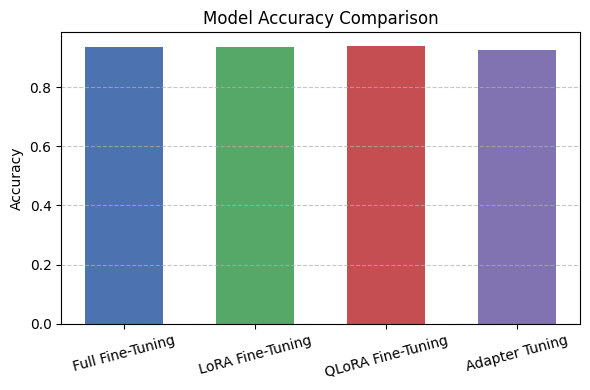

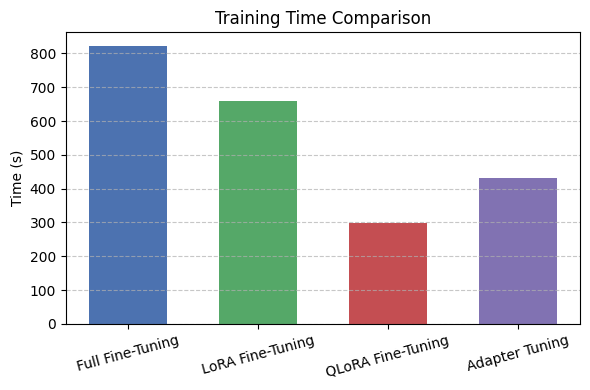

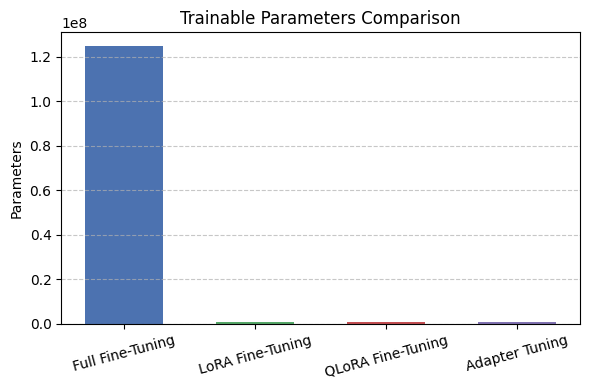

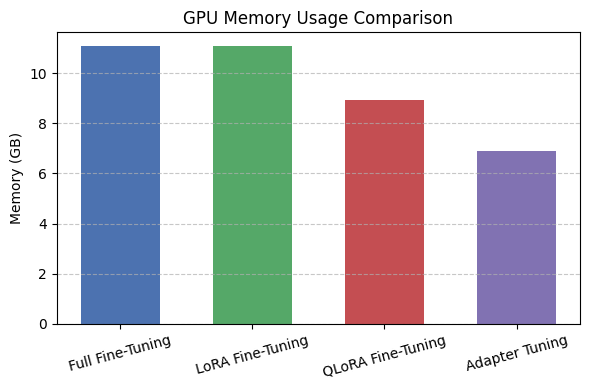

In [42]:
# Common settings
x = np.arange(len(models))
bar_width = 0.6
colors = ['#4c72b0', '#55a868', '#c44e52', '#8172b2']

# Plot 1: Accuracy
plt.figure(figsize=(6, 4))
plt.bar(x, accuracy, width=bar_width, color=colors)
plt.xticks(x, models, rotation=15)
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot 2: Training Time
plt.figure(figsize=(6, 4))
plt.bar(x, training_time, width=bar_width, color=colors)
plt.xticks(x, models, rotation=15)
plt.ylabel('Time (s)')
plt.title('Training Time Comparison')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot 3: Trainable Parameters
plt.figure(figsize=(6, 4))
plt.bar(x, trainable_params, width=bar_width, color=colors)
plt.xticks(x, models, rotation=15)
plt.ylabel('Parameters')
plt.title('Trainable Parameters Comparison')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot 4: GPU Memory Usage
plt.figure(figsize=(6, 4))
plt.bar(x, gpu_memory, width=bar_width, color=colors)
plt.xticks(x, models, rotation=15)
plt.ylabel('Memory (GB)')
plt.title('GPU Memory Usage Comparison')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Part 5 Analyziz and Discussion

In this section, we evaluate and compare four fine-tuning techniques — Full Fine-Tuning, LoRA Fine-Tuning, QLoRA Fine-Tuning, and Adapter Tuning — across four key dimensions: accuracy, training time, number of trainable parameters, and GPU memory usage. These metrics help us understand the trade-offs in terms of performance, resource efficiency, and scalability.
 Trade-Off Analysis

    Accuracy

        QLoRA achieves the highest accuracy (93.8%), slightly surpassing Full Fine-Tuning (93.6%).

        LoRA also performs well (93.4%), whereas Adapter Tuning shows a slightly lower performance (92.6%).

        This indicates that parameter-efficient methods like QLoRA and LoRA can maintain high performance without updating the full model.

    Training Time

        QLoRA has the shortest training time (298 seconds), significantly reducing training cost.

        Adapter Tuning also trains quickly (433 seconds).

        In contrast, Full Fine-Tuning is the most time-consuming (821 seconds), followed by LoRA (660 seconds).

        This shows that quantization and adapter-based methods are more time-efficient.

    Trainable Parameters

        Full Fine-Tuning involves updating the entire model (~125 million parameters), which is resource-intensive.

        LoRA, QLoRA, and Adapter Tuning only update a small subset (~0.7–0.88 million parameters), making them highly parameter-efficient.

        This is particularly beneficial for deploying models in limited environments or frequent re-training scenarios.

    GPU Memory Usage

        Adapter Tuning uses the least GPU memory (6.9 GB), followed by QLoRA (8.94 GB).

        LoRA and Full Fine-Tuning both consume around 11.07 GB.

        This makes Adapter and QLoRA attractive for environments with restricted GPU capacity.

 Best Use Cases for Each Method

    Full Fine-Tuning

        Best for: High-resource settings requiring full control over model parameters.

        Use cases: Training on large, domain-specific datasets where model flexibility and maximum performance are required (e.g., industrial NLP pipelines, research labs).

    LoRA Fine-Tuning

        Best for: Scenarios that balance performance and efficiency.

        Use cases: Tasks with moderate resources where regular updates are needed (e.g., evolving datasets, production models).

    QLoRA Fine-Tuning

        Best for: Low-resource environments with limited GPU memory and compute budget.

        Use cases: Academic projects, startups, and on-device fine-tuning where high accuracy is desired with minimal resources.

    Adapter Tuning

        Best for: Extremely lightweight and modular training setups.

        Use cases: Applications needing fast switching between tasks, such as multilingual or multi-domain assistants, with minimal hardware requirements.

In summary, QLoRA stands out as a balanced solution, providing both high performance and efficiency. Full Fine-Tuning remains the best when accuracy is paramount and resources are ample. LoRA and Adapter Tuning offer excellent alternatives for rapid, low-cost fine-tuning with reasonable accuracy.
